![20221125110654](https://cdn.jsdelivr.net/gh/xihuishawpy/PicBad@main/blogs/pictures/20221125110654.png)

In [2]:
import gzip
import json
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import paddle
import paddle.nn.functional as F
from PIL import Image

In [22]:
def load_data(mode="train"):
    data = json.load(gzip.open("mnist.json.gz"))

    train_set, val_set, eval_set = data

    # 图片高度IMG_ROWS, 宽度IMG_COLS
    IMG_ROWS = 28
    IMG_COLS = 28

    if mode == "train":
        imgs, labels = train_set[0], train_set[1]
    elif mode == "valid":
        imgs, labels = val_set[0], val_set[1]
    elif mode == "eval":
        imgs, labels = eval_set[0], eval_set[1]
    else:
        raise Exception("mode can only be one of ['train', 'valid', 'eval']")

    # 校验数据
    imgs_length = len(imgs)
    assert len(imgs) == len(
        labels
    ), "length of train_imgs({}) should be the same as train_labels({})".format(
        len(imgs), len(labels)
    )

    index_list = list(range(imgs_length))
    BATCHSIZE = 100

    # 定义数据生成器
    def data_generator():
        if mode == "train":
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            img = np.array(imgs[i]).astype("float32")
            label = np.array(labels[i]).astype("float32")

            # 注意：用卷积神经网络结构时，不注释掉下面两行代码
            img = np.reshape(imgs[i], [1, IMG_ROWS, IMG_COLS]).astype("float32")
            label = np.reshape(labels[i], [1]).astype("float32")

            imgs_list.append(img)
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                yield np.array(imgs_list), np.array(labels_list)
                imgs_list = []
                labels_list = []

        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator

## 1、多层全连接

为什么激活函数都是非线性的？

在神经网络的计算过程中，每层都相当于矩阵相乘，无论神经网络有多少层输出都是输入的线性组合，就算我们有几千层的计算，无非还是个矩阵相乘，和一层矩阵相乘所获得的信息差距不大，所以需要激活函数来引入非线性因素，使得神经网络可以任意逼近任何非线性函数，这样神经网络就可以应用到众多的非线性模型中，增加了神经网络模型泛化的特性。

(神经网络简介)[https://handbook.pytorch.wiki/chapter2/2.3-deep-learning-neural-network-introduction.html]

In [7]:
import paddle.nn.functional as F
from paddle.nn import Linear


class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        self.fc1 = Linear(784, 10)
        self.fc2 = Linear(10, 10)
        self.fc3 = Linear(10, 1)

    def forward(self, input):
        output1 = self.fc1(input)
        output1 = F.sigmoid(output1)
        output2 = self.fc1(output1)
        output2 = F.sigmoid(output2)
        output_final = self.fc3(output2)
        return output_final

## 2、卷积网络

![20221125140406](https://cdn.jsdelivr.net/gh/xihuishawpy/PicBad@main/blogs/pictures/20221125140406.png)

https://blog.csdn.net/qq_25762497/article/details/51052861

In [7]:
from paddle.nn import Conv2D, Linear, MaxPool2D

# 定义网络
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        # 输入是[1, 1, IMG_ROWS, IMG_COLS] ，参数依次代表：样本数、通道数、图片高度、图片宽度
        # 只支持mini-batches，不支持一次只输入一个样本，即一次必须是一个batch，就算输入一个样本，也会对样本进行分批，所以所有的输入都会增加一个维度
        # nn中定义为3维，但人工创建时多增加了一个维度，变为了4维，最前面的1即为batch-size
        # 因为是灰度图片，所以只有1个通道  
        # 卷积
        self.conv1 = Conv2D( 
            in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2
        )
        # 池化
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        self.conv2 = Conv2D(
            in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2
        )
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        self.fc = Linear(in_features=980, out_features=10)

    def forward(self,input,label):
        x = self.conv1(input)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc(x)
        # 训练时，同时输出训练集准确率
        if label is not None:
            acc = paddle.metric.accuracy(x,label)
            return x ,acc 
        else : 
            return x
        

In [27]:
def train():
    # 实例化模型，开启训练
    model = MNIST()
    model.train()
    
    # 初始化数据生成器
    train_loader = load_data("train")
    # 定义优化算法
    opt = paddle.optimizer.SGD(learning_rate=0.01, 
                                # 优化算法加入正则化
                               weight_decay = paddle.regularizer.L2Dacey(coff=1e-5) ,
                               parameters=model.parameters())

    EPOCH_NUM = 5
    # MNIST图像高和宽
    IMG_ROWS, IMG_COLS = 28, 28
    loss_list = []
    
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            # 准备数据，转成paddle tensor格式
            images, labels = data
            images = paddle.to_tensor(images, dtype="float32")
            labels = paddle.to_tensor(labels, dtype="float32")

            # 前向传播过程
            predicts = model(images)

            # 计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)

            if batch_id % 200 == 0:
                loss = avg_loss.numpy()[0]
                loss_list.append(loss)
                print(
                    "epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, loss)
                )
            # 反向传播，更新参数，清除梯度待下一轮使用
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
    # 保存模型
    paddle.save(model.state_dict(), "mnist.pdparams")
    return loss_list


loss_list = train()

epoch: 0, batch: 0, loss is: 21.329179763793945
epoch: 0, batch: 200, loss is: 8.300498008728027
epoch: 0, batch: 400, loss is: 8.968539237976074
epoch: 1, batch: 0, loss is: 6.975785732269287
epoch: 1, batch: 200, loss is: 8.25076675415039
epoch: 1, batch: 400, loss is: 8.384908676147461
epoch: 2, batch: 0, loss is: 8.682323455810547
epoch: 2, batch: 200, loss is: 8.71716594696045
epoch: 2, batch: 400, loss is: 7.6802802085876465
epoch: 3, batch: 0, loss is: 5.304437637329102
epoch: 3, batch: 200, loss is: 5.369511604309082
epoch: 3, batch: 400, loss is: 5.374788761138916
epoch: 4, batch: 0, loss is: 4.861802101135254
epoch: 4, batch: 200, loss is: 2.2799789905548096
epoch: 4, batch: 400, loss is: 2.395460844039917


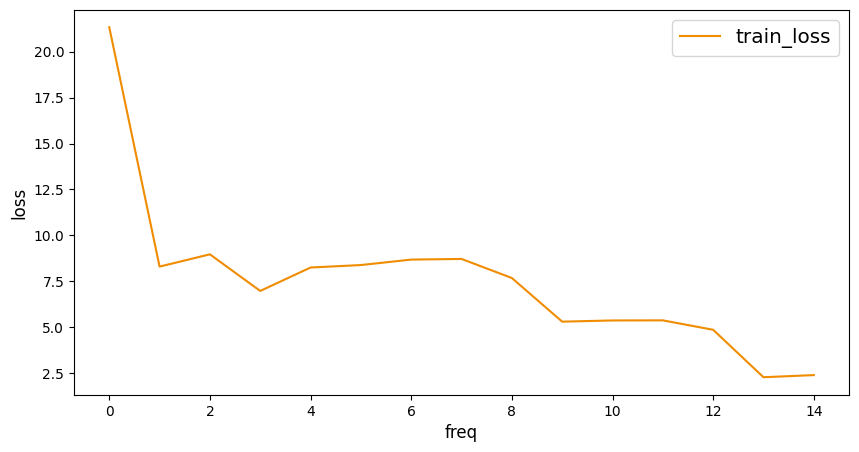

In [28]:
# 每200batch 的 agv_loss
def plot(loss_list):
    plt.figure(figsize=(10, 5))
    freqs = [i for i in range(len(loss_list))]              
    plt.plot(freqs, loss_list, color="#f08c00", label="train_loss")
    plt.ylabel("loss", fontsize="large")
    plt.xlabel("freq", fontsize="large")
    plt.legend(loc="upper right", fontsize="x-large")
    plt.show()


plot(loss_list)

In [4]:
# 异步读取数据集（继承paddle.io.Dataset类）

class MNISTDataset(paddle.io.Dataset):
    def __init__(self,mode):
        data = json.load(gzip.open('mnist.json.gz'))
        train_set, val_set, eval_set = data
        
        self.IMG_ROW = 28
        self.IMG_COL = 28
        
        if mode == 'train':
            imgs , labels = train_set[0] , train_set[1]
        elif mode =='valid':
            imgs , labels = val_set[0] , val_set[1]
        elif mode =='eval':
            imgs , labels = eval_set[0] , eval_set[1]
        else :
            raise Exception('只有train 、valid、eval模式')
        self.imgs = imgs
        self.labels = labels 
    
    def __getitem__(self,idx):
        img = np.reshape(self.imgs[idx],[1,self.IMG_ROW,self.IMG_COL]).astype('float32')  
        label = np.reshape(self.labels[idx], [1]).astype('int64')
        return img, label
    
    def __len__(self):
        return len(self.imgs)

In [5]:
# 异步读取
# DataLoader返回的一个批次数据迭代器（异步）
train_dataset = MNISTDataset(mode='train')
train_loader = paddle.io.DataLoader(train_dataset,batch_size =100,shuffle=True,drop_last=True)

In [5]:
# 测试集 分类准确率
def evaluation(model,dataset):
    model.eval()
    acc_set = []
    for batch_id ,data in enumerate(dataset()):
        images ,labels = data 
        images = paddle.to_tensor(images,dtype='float32')
        labels = paddle.to_tensor(labels)
        
        predicts = model.forward(images)
        acc = paddle.metric.accuracy(predicts,label=labels)
        acc_set.expend(acc.numpympy())
        
    acc_mean = np.mean(acc_set).mean()
    return acc_mean
        

In [8]:
# 引入VisualDL库，设定保存作图数据的位置
from visualdl import LogWriter
log_writer = LogWriter(logdir="./log")

# 命令行打印出可用浏览器查阅图形结果的网址
# visualdl --logdir ./log --port 8080


def train(model):
    model.train()
    opt = paddle.optimizer.SGD(learning_rate=0.001,parameters=model.parameters())
    
    EPOCH = 5
    iter = 0 
    for epoch_id in range(EPOCH):
        for batch_id , data in enumerate(train_loader()):
            imgs , labels = data 
            imgs = paddle.to_tensor(imgs,dtype='float32')
            labels = paddle.to_tensor(labels) 
            
            predicts, avg_acc = model.forward(imgs,labels) 
            loss = F.cross_entropy(predicts , label=labels)
            avg_loss = paddle.mean(loss)
            
            if batch_id % 100 ==0:
                print(f'epoch_id:{epoch_id},batch_id:{batch_id},loss:{avg_loss.numpy()}')
                log_writer.add_scalar(tag = 'acc', step= iter , value = avg_acc.numpy())
                log_writer.add_scalar(tag = 'loss', step = iter, value = avg_loss.numpy())
                iter = iter + 100

            
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
            
    paddle.save(model.state_dict(),'minist.pdparams')
    

# run
model = MNIST()
train(model)            

epoch_id:0,batch_id:0,loss:[2.9534736]
epoch_id:0,batch_id:100,loss:[2.2011197]
epoch_id:0,batch_id:200,loss:[1.9832315]
epoch_id:0,batch_id:300,loss:[1.6718711]
epoch_id:0,batch_id:400,loss:[1.4264364]
epoch_id:1,batch_id:0,loss:[1.2948554]
epoch_id:1,batch_id:100,loss:[1.1684717]
epoch_id:1,batch_id:200,loss:[0.9226985]
epoch_id:1,batch_id:300,loss:[0.8809623]
epoch_id:1,batch_id:400,loss:[0.80619353]
epoch_id:2,batch_id:0,loss:[0.63037795]
epoch_id:2,batch_id:100,loss:[0.5284833]
epoch_id:2,batch_id:200,loss:[0.554456]
epoch_id:2,batch_id:300,loss:[0.4999768]
epoch_id:2,batch_id:400,loss:[0.52954394]
epoch_id:3,batch_id:0,loss:[0.6498244]
epoch_id:3,batch_id:100,loss:[0.41705242]
epoch_id:3,batch_id:200,loss:[0.44747248]
epoch_id:3,batch_id:300,loss:[0.41162527]
epoch_id:3,batch_id:400,loss:[0.32739994]
epoch_id:4,batch_id:0,loss:[0.3301551]
epoch_id:4,batch_id:100,loss:[0.40678146]
epoch_id:4,batch_id:200,loss:[0.45640153]
epoch_id:4,batch_id:300,loss:[0.40829605]
epoch_id:4,batch_

In [ ]:
# 读取本地图片，转变成模型输入的格式
def load_image(img_path):
    # 读取图像,并转为灰度图
    im = Image.open(img_path).convert('L')
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32) 
    # 图像归一化
    im = 1.0 - im / 255.
    return im



# 定义预测过程
model = MNIST()
params_file_path = 'mnist.pdparams'
img_path = 'example_0.jpg'

# 加载模型参数
param_dict = paddle.load(params_file_path)
model.load_dict(param_dict)

# 开启预测
model.eval()
tensor_img = load_image(img_path)
# 模型结果，10个分类标签的对应概率
results = model(paddle.to_tensor(tensor_img))
# 取概率最大的标签作为预测输出
lab = np.argsort(results.numpy())